# Ce notebook permet d'effectuer une prédiction et d'afficher le Grad Cam de l'image évaluée  

Le code permet simplement de changer de modèle entre :  
- VGG16  
- ResNet50
- EfficientNetB0

Arborescence de référence :
--
Répertoire de référence du projet : ./ChampySeed  
Dézipper les images dans ce répertoire : ./ChampySeed/data/

Copier ce Notebook ainsi que les fihciers "*.h5 et les "*.csv" à la racine du projet : ./ChampySeed


In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

## Choisissez ici le modèle que vous souhaitez tester

Décommenter la ligne correspondant au modèle souhaité

In [2]:
# Décommenter 1 ligne
#model_to_evaluate = "VGG16"
model_to_evaluate = "ResNet50"
# model_to_evaluate = "EfficientNetB0"


if model_to_evaluate == "VGG16":
    from tensorflow.keras.applications.vgg16 import preprocess_input
    #from tensorflow.keras.applications import VGG16
    model_builder = tf.keras.applications.VGG16
    #model_builder = VGG16
    conv_layer = 'block5_conv3'
elif model_to_evaluate == "ResNet50":
    from tensorflow.keras.applications.resnet50 import preprocess_input
    #from tensorflow.keras.applications import ResNet50
    model_builder = tf.keras.applications.ResNet50
    conv_layer = 'conv5_block3_out'
elif model_to_evaluate == "EfficientNetB0":
    from tensorflow.keras.applications.efficientnet import preprocess_input
    #from tensorflow.keras.applications import EfficientNetB0
    model_builder = tf.keras.applications.EfficientNetB0
    conv_layer = 'MBConv6'
else:
    print("Modèle inconnu ou non supporté")

## Choisissez la variable cible que vous voulez
Afin de charger le modèle adéquat, précisez si vous voulez identifier le Genre ou l'Espèce du champignon

In [3]:
# Décommenter 1 ligne
#target_class = "genus"
target_class = "species"

# Important au moment de la prédiction pour savoir si on utilise le preprocess_input ou l'alternative
# On tente la valeur choisie mais elle peut être changée si cette option n'est pas compatible avec les autres choix
IDG_available = True

if target_class == "genus":
    class_names = ['Amanita', 'Trametes', 'Mycena', 'Russula', 'Lactarius',
       'Cortinarius', 'Fomitopsis', 'Stereum', 'Ganoderma', 'Cerioporus',
       'Laetiporus', 'Hygrocybe', 'Schizophyllum', 'Suillus', 'Pleurotus',
       'Hypholoma', 'Fomes', 'Boletus', 'Coprinus', 'Coprinellus',
       'Auricularia', 'Tricholoma', 'Agaricus', 'Laccaria', 'Coprinopsis',
       'Entoloma', 'Pluteus', 'Exidia', 'Lycoperdon', 'Pholiota',
       'Phellinus', 'Armillaria', 'Cantharellus', 'Clitocybe',
       'Chlorophyllum', 'Phallus', 'Gymnopilus', 'Leccinum', 'Lepista',
       'Flammulina', 'Marasmius', 'Leratiomyces', 'Geastrum',
       'Daedaleopsis', 'Polyporus', 'Hericium', 'Macrolepiota', 'Phlebia',
       'Psathyrella', 'Panellus', 'Lentinus', 'Inocybe', 'Gymnopus',
       'Phaeolus', 'Apioperdon', 'Stropharia', 'Scleroderma', 'Galerina',
       'Omphalotus', 'Bjerkandera', 'Hohenbuehelia', 'Bolbitius',
       'Ramaria', 'Hygrophorus']
    
    if model_to_evaluate == "VGG16":
        saved_model = tf.keras.models.load_model('vgg16_64genus_noIDG.h5')
        IDG_available = False
        saved_layers = saved_model.get_layer('vgg16')
    elif model_to_evaluate == "ResNet50":
        saved_model = tf.keras.models.load_model('res50_64genusIDG.h5')
        IDG_available = True
        saved_layers = saved_model.get_layer('resnet50')
    elif model_to_evaluate == "EfficientNetB0":
        saved_model = tf.keras.models.load_model('efficientnet_64genus_IDG.h5')
        IDG_available = True
        saved_layers = saved_model.get_layer('efficientnet')
    else:
        print("Modèle inconnu ou non supporté")
elif target_class == "species":
    class_names = ['Amanita muscaria', 'Trametes versicolor', 'Schizophyllum commune',
       'Cerioporus squamosus', 'Fomes fomentarius', 'Coprinus comatus',
       'Laetiporus sulphureus', 'Fomitopsis betulina',
       'Fomitopsis pinicola', 'Hypholoma fasciculare',
       'Pleurotus ostreatus', 'Stereum hirsutum',
       'Auricularia auricula-judae', 'Amanita rubescens',
       'Flammulina velutipes', 'Coprinellus micaceus',
       'Daedaleopsis confragosa', 'Ganoderma applanatum',
       'Phaeolus schweinitzii', 'Apioperdon pyriforme', 'Boletus edulis',
       'Lepista nuda', 'Lycoperdon perlatum', 'Bjerkandera adusta',
       'Bolbitius titubans', 'Macrolepiota procera',
       'Chlorophyllum molybdites', 'Clitocybe nebularis',
       'Pluteus cervinus', 'Leratiomyces ceres', 'Trametes gibbosa',
       'Hohenbuehelia serotina', 'Coprinellus disseminatus',
       'Panellus stipticus', 'Phallus impudicus', 'Scleroderma citrinum',
       'Trametes hirsuta', 'Armillaria mellea', 'Exidia glandulosa',
       'Stereum ostrea', 'Leccinum scabrum', 'Laccaria amethystina',
       'Phlebia radiata', 'Hygrocybe conica', 'Gymnopilus junonius',
       'Amanita fulva', 'Amanita citrina', 'Cantharellus cibarius',
       'Mycena haematopus', 'Coprinopsis lagopus', 'Amanita phalloides',
       'Fomitopsis mounceae', 'Pleurotus pulmonarius', 'Laccaria laccata',
       'Mycena galericulata', 'Galerina marginata', 'Hericium erinaceus',
       'Coprinopsis atramentaria', 'Ganoderma tsugae',
       'Amanita pantherina', 'Geastrum triplex', 'Pholiota squarrosa',
       'Omphalotus olivascens', 'Hericium coralloides']
    
    if model_to_evaluate == "VGG16":
        if IDG_available == True:
            saved_model = tf.keras.models.load_model('vgg16-64species-IDG.h5')
        else:
            saved_model = tf.keras.models.load_model('VGG16_64species_noIDG.h5')
            IDG_available = False
        saved_layers = saved_model.get_layer('vgg16')
    elif model_to_evaluate == "ResNet50":
        #saved_model = tf.keras.models.load_model('resnet5064speciesIDG.h5')
        saved_model = tf.keras.models.load_model('resnet64speciesIDG.h5')
        IDG_available = True
        saved_layers = saved_model.get_layer('resnet50')
    elif model_to_evaluate == "EfficientNetB0":
        saved_model = tf.keras.models.load_model('xxx.h5')
        IDG_available = True
        saved_layers = saved_model.get_layer('xxx')
    else:
        print("Modèle inconnu ou non supporté")
else:
    print("Classe inconnue ou non prédite")
    
# ImageDataGenerator trie les labels par ordre alphabétique mais pas notre alternative à IDG
if IDG_available == True:
    class_names = sorted(class_names)

## Récapitulatif de ce que vous avez choisi :
- Le modèle
- Ce que vous souhaitez reconnaitre
- La liste des classes entraînées

In [4]:
print("Modèle choisi : ", model_to_evaluate)
print("Dont voici les couches :")
saved_model.summary()
print("\n")
print("Avec ImageDataGenerator ? ", IDG_available)
print("\n")
print("Vous avez choisi de reconnaitre les :", target_class)
print("\n")
print("Dont voici les noms potentiels :\n", class_names)

Modèle choisi :  ResNet50
Dont voici les couches :
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense

## Chargement du csv contenant les chemins des images sur le HDD
Cellule ajoutée par confort si vous souhaitez évaluer le notebook sans spécifier vos propres images

In [5]:
# Chargement du fichier
df = pd.read_csv ("Champyseed.csv", index_col=0)

# On ajoute le chemin où se trouve l'arborescence précédente (peut varier si l'arborescence est différente de celle décrite plus haut)
base_dir = './data/esperons'

df["path"] = base_dir+df["path"]
df.head()

C:\Users\bhozj\anaconda3\envs\tf-gpu\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Unnamed: 0.1,id,identifier_y,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,notreid,fungi_class
0,106,3022624752,https://files.plutof.ut.ee/public/large/80/6C/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius meinhardii,"Cortinarius meinhardii Bon, 1986",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,106,Fungi
1,108,3022625110,https://files.plutof.ut.ee/public/large/4B/5B/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius delibutus,"Cortinarius delibutus Fr., 1838",EE,58.02667,26.57722,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,108,Fungi
2,109,3022625373,https://files.plutof.ut.ee/public/large/C9/A4/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius prasinus,"Cortinarius prasinus (Schaeff.) Fr., 1838",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,109,Fungi
3,110,3022625373,https://files.plutof.ut.ee/public/large/C4/51/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius prasinus,"Cortinarius prasinus (Schaeff.) Fr., 1838",EE,58.02611,22.16833,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,110,Fungi
4,111,3022625785,https://files.plutof.ut.ee/public/large/19/E7/...,Agaricales,Cortinariaceae,Cortinarius,Cortinarius infractus,"Cortinarius infractus (Pers.) Fr., 1838",EE,58.75333,23.17167,True,./ChampImages2/Agaricales/Cortinariaceae/Corti...,111,Fungi


## Test prédictions 

On affiche les probabilités du champignon testé avec les 10 classes puis le nom de la classe choisie

Notre fonction my_decode_prediction() permet d'afficher le résultat de la prédiction


In [6]:
# Fonction qui décode le résultat obtenu après un model.predict()
def my_decode_prediction(pred, classes, top = 1, threshold = 0.2):
    """
    Cette fonction compte le nombre total d'éléments dans une liste de listes
    
    Paramètres:
    pred           : La liste des probabilités retournées par model.predict()
    classes        : Les noms des labels
    top            : Le nombre de label les plus probables à retourner (équivalent d'un top-k)
    threshold      : Le seuil de probabilité minimal requis pour faire partie des labels retenus
    
    Renvoie:
    Un dataframe contenant les probabilité triées dans une première colonne et le nom de label dans la seconde colonne.
    """

    # On initialise une liste vide dans laquelle nous conserveront les labels retenus
    pred_after_threshold = []
    
    # On évalue chaque probabilité de toutes les classes
    for p in range(0,len(pred)):
        # Si la probabilité est supérieure à un seuil nous la gardons
        if pred[p] >= threshold:
            pred_after_threshold.append([pred[p], classes[p]])
       
    # La liste est triée pour avoir les plus grandes probalités au début
    pred_after_threshold = sorted(pred_after_threshold, reverse = True)
    
    # Nous ne renvoyons que les 'top' premières valeures
    if top < len(pred)+1:
        return pd.DataFrame(pred_after_threshold).head(top)
    else:
        return pd.DataFrame(pred_after_threshold).head(1)

## Prédiction de la classe d'un champignon sur une photo
Vous pouvez au choix :
- Exécuter la cellule suivante qui va chercher une image pour vous aléatoirement dans le dataset chargé pour votre confort
- Remplacer la variable 'filename' par le chemin d'un fichier sur votre disque dur

./ChampImages2/Polyporales/Meruliaceae/Bjerkandera/Bjerkandera adusta/im1204201.jpg


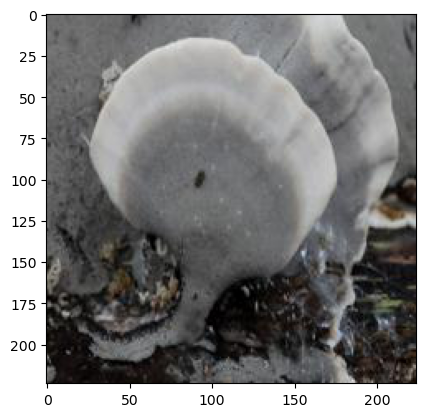

Probabilité pour les toutes les classes : [[7.8762518e-08 5.3391062e-08 2.3690219e-10 3.5647219e-07 1.3623202e-05
  1.5081904e-06 5.0960296e-08 1.9362438e-05 2.1282052e-05 7.7977741e-01
  1.4816845e-10 1.4163936e-06 7.3555149e-09 1.5649926e-05 6.1493483e-06
  6.0246974e-02 1.2816421e-08 1.7057087e-07 3.4124851e-06 3.5967760e-06
  1.8192864e-07 1.1932208e-03 1.1298281e-06 5.8500169e-09 4.5214441e-05
  2.5465805e-04 7.5420212e-05 6.7053735e-04 1.5197504e-09 3.7958147e-03
  1.7759721e-05 5.5484441e-07 6.7242475e-11 7.1572037e-10 2.1989836e-06
  1.7571774e-03 8.6913227e-11 3.3570473e-07 3.6668275e-06 2.1218870e-08
  1.5576728e-05 8.4909448e-07 1.3227800e-03 6.8686029e-10 1.3532315e-07
  3.8728158e-06 2.1434177e-04 4.2767752e-08 6.7881638e-07 1.0976867e-05
  2.5530122e-04 7.2204358e-08 2.2175401e-07 1.6742942e-07 5.6056779e-02
  7.2495465e-04 5.3629847e-03 8.1726983e-05 2.1222615e-06 5.3027208e-05
  6.8422669e-04 2.4378365e-03 4.9500134e-02 3.5342153e-02]]


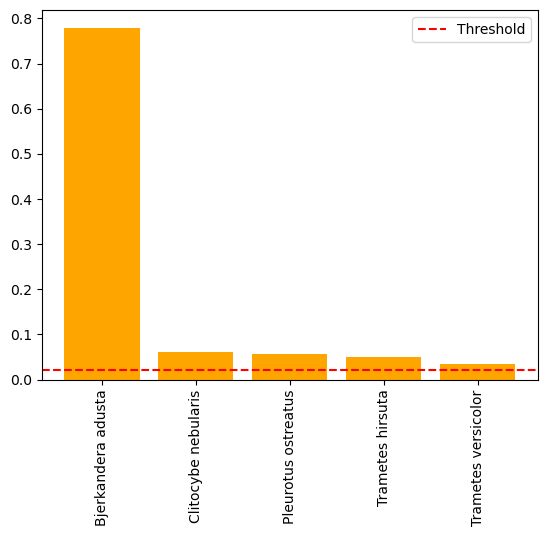

In [16]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

# On pioche au hasard un fichier dans le dataset
filename = df.path.iloc[np.random.randint(len(df))]

# Ou bien décommenter la ligne suivante en mettant le chemin vers votre fichier
#filename = "./mon_champignon_prefere.jpg"

print(filename)

# Chargement du fichier
img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Préprocessing de l'image pour être compatible avec le modèle
img = image.img_to_array(img)

if IDG_available == True:
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
else:
    img = np.expand_dims(img, axis=0)
    img -=np.mean(img)
    img /=np.std(img)

# Prédiction
output = saved_model.predict(img)

# Affichage du tableau des probabilités pour chaque classe 
print("Probabilité pour les toutes les classes :", output)
#print("Classe présentie :", classes[output.argmax()])


# Seuil de probalibilité en dessous duquel nous ignorons les candidats
threshold = 0.02

# Récupération des meilleurs candidats
decode = my_decode_prediction(pd.DataFrame(output[0])[0], class_names, top = 5, threshold = threshold)

# Affichage des candidats demandés
plt.bar(decode[1], height = decode[0], color = "orange")
plt.xticks(rotation=90)
plt.axhline(y=threshold, color='r', linestyle='--', label = "Threshold")
plt.legend()
plt.show()

## Grad Cam
Il s'agit ici de générer une heatmap représentative des zônes de l'image qui ont le plus contribué à prédire le champignon.  
Les fonctions get_img_array(), make_gradcam_heatmap() et save_and_display_gradcam() proviennent directement de keras.  


In [17]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [18]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [19]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image and heatmap
    superimposed_img.save(cam_path)
    tf.keras.preprocessing.image.array_to_img(jet_heatmap).save("heatmap.jpg")

    # Display Grad CAM
    display(Image(cam_path))

## Nous devons maintenant recontruire le modèle à partir du fichier h5 chargé

In [20]:
# On instancie un nouveau modèle à partir du choix de l'utilisateur
model_gradCam = model_builder(input_shape=(224, 224,3), 
                      include_top=True, 
                      weights="imagenet")

# Nous recopions les couches du modèle contenu dans le fichier h5 dans le nouveau modèle instancié
for layer, dense_layer in zip(model_gradCam.layers[1:], saved_layers.layers[1:]):
    layer.set_weights(dense_layer.get_weights())

# Affichage de la description du modèle
model_gradCam.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## On calcule la heatmap et on l'affiche

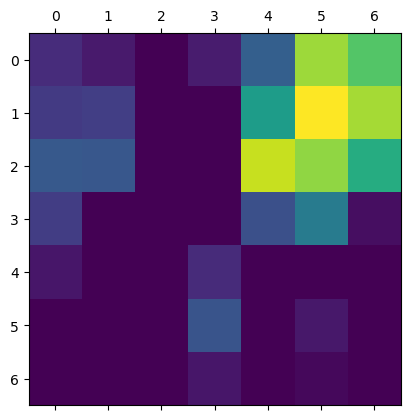

In [21]:
# Préprocess de l'image pour la mettre dans le format attendu par le modèle
img_array = preprocess_input(get_img_array(filename, size=(224, 224)))

# Génération de la Heatmap
# Le paramètre 'conv_layer' contient le nom de la dernière couche de convolution du modèle
heatmap = make_gradcam_heatmap(img_array, model_gradCam, conv_layer) 

# Affichage de la Heatmap
plt.matshow(heatmap)
plt.show()

## Nous pouvons maintenant afficher la superposition de la heatmap sur la photo évaluée
On peut ainsi vérifier si la zône la plus active (jaune/rouge) de la heatmap se superpose à la zône de l'image où se trouve le champignon

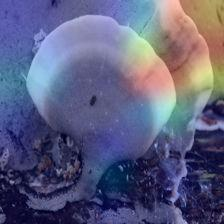

In [22]:
save_and_display_gradcam(filename, heatmap)